<a href="https://colab.research.google.com/github/lisaong/diec/blob/rl_path_finding/day4/rl/path_finding_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning Path-Finding Demo

This demonstrates how to:
- Use OpenAI gym to create a custom environment
- Compare different Q-learning algorithms for Reinforcement Learning

Inspired by: http://mnemstudio.org/path-finding-q-learning-tutorial.htm

## Problem Setup

Bender is lost in Fry's house! Help Bender find Fry (who is in Room 5 waiting with a can of beer).

![intro](https://github.com/lisaong/diec/raw/rl_path_finding/day4/rl/path_finding_intro.png)

## OpenAI Gym

[OpenAI Gym](https://gym.openai.com/) is an open-source Python toolkit for developing RL algorithms.

We will use OpenAI gym to re-create Fry's house, then run some reinforcement learning to find the path.

https://github.com/openai/gym/blob/master/docs/creating-environments.md


In [14]:
# gym is already built into Colab
import gym
from gym import spaces
import numpy as np
import random

gym.__version__

'0.15.6'

In [0]:
#
# A Simple Path Finding OpenAI Gym Environment
#
# Inspired by: http://mnemstudio.org/path-finding-q-learning-tutorial.htm
#

import gym
from gym import spaces
import numpy as np
import random

class FrysHomeEnv(gym.Env):
  """Custom Environment describing Fry's home  
  
  For details on the gym.Env class:
  https://github.com/openai/gym/blob/master/gym/core.py
  """

  # render to the current display or terminal
  metadata = {'render.modes': ['human']}

  def __init__(self, rewards):
    super(FrysHomeEnv, self).__init__()

    self.rewards = rewards
    self.num_rooms = self.rewards.shape[0]

    # Action space describes all possible actions that can be taken
    # here, we can select 1 out of 6 rooms
    self.action_space = spaces.Discrete(self.num_rooms)

    # Observation space describes the valid observations
    # since we are moving between rooms, we can be in 1 of 6 rooms
    self.observation_space = spaces.Discrete(self.num_rooms)

    # Rewards range describes the min and max possible rewards
    self.reward_range = (self.rewards.min(), self.rewards.max())

    # Room 5 is our goal
    self.goal = 5

    # Initialise our state
    self.reset()

  def reset(self):
    """Reset the environment to an initial state"""

    # Randomly initialise the state
    self.state = random.randint(0, self.num_rooms-1)

    # Return the observation (same as the state in our case)
    obs = self.state
    return obs

  def step(self, action):
    """Execute one step within the environment"""

    # take the selected action
    prev_state = self.state
    self.state = action

    # calculate the reward
    reward = self.rewards[prev_state][action]

    # check if we've reached our goal
    done = (prev_state == self.goal or self.state == self.goal)

    # get the next observation
    obs = self.state

    return obs, reward, done, {}

  def render(self, mode='human', close=True):
    """Print state of the current environment"""
    print(f'Current room: {self.state}, Reached goal: {self.state == self.goal}')

In [10]:
# Unit testing

# Initialise the rewards matrix for the rooms in the house
# Where:
#  state: current room, action: next room
#  dimensions (row=state, col=actions)
#  A value of -1 means there is no adjacent path from room_i to room_j
#  (for example, room_0 to room_0 has, room_0 to room_5)
R = np.array([[-1, -1, -1, -1,  0, -1], # action 0
              [-1, -1, -1,  0, -1, 0],  # action 1
              [-1, -1, -1,  0, -1, -1], # etc
              [-1,  0,  0, -1,  0, -1],
              [ 0, -1, -1,  0, -1,  0],
              [-1, 100, -1, -1, 100, 100]])

myenv = FrysHomeEnv(rewards=R)

for i in range(0, 6):
  print(myenv.step(i))
  myenv.render()

(0, -1, True, {})
Current room: 0, Reached goal: False
(1, -1, False, {})
Current room: 1, Reached goal: False
(2, -1, False, {})
Current room: 2, Reached goal: False
(3, 0, False, {})
Current room: 3, Reached goal: False
(4, 0, False, {})
Current room: 4, Reached goal: False
(5, 0, True, {})
Current room: 5, Reached goal: True


## Package custom environment as module

OpenAI gym requires all environments to be packaged as Python modules.

The code above has been packaged here:
https://github.com/lisaong/diec/blob/master/day4/rl/gym-fryshome

The module follows this convention:
https://github.com/openai/gym/blob/master/docs/creating-environments.md

In [11]:
!git clone -b rl_path_finding https://github.com/lisaong/diec.git
%cd diec/day4/rl/gym-fryshome
!git pull
!pip install --verbose -e  .

fatal: destination path 'diec' already exists and is not an empty directory.
/content/diec/day4/rl/gym-fryshome
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 17 (delta 11), reused 12 (delta 7), pack-reused 0
Unpacking objects: 100% (17/17), done.
From https://github.com/lisaong/diec
   f52e36d..b8d2558  rl_path_finding -> origin/rl_path_finding
Updating f52e36d..b8d2558
Fast-forward
 .../gym_fryshome/envs/frys_home_env.py             |  16 +-
 day4/rl/path_finding_demo.ipynb                    | 254 ++++++++++++---------
 2 files changed, 144 insertions(+), 126 deletions(-)
Created temporary directory: /tmp/pip-ephem-wheel-cache-39sk297y
Created temporary directory: /tmp/pip-req-tracker-w83an5vv
Created requirements tracker '/tmp/pip-req-tracker-w83an5vv'
Created temporary directory: /tmp/pip-install-883a0bjx
Obtaining file:///content/diec/day4/rl/gym-fryshome
  Added file:///content/d

## ** Restart the Colab kernel after every pip install**

Runtime -> Restart Runtime

In [2]:
# IMPORTANT: RESTART THE COLAB KERNEL if you've just run !pip install

# Test the installation
import gym_fryshome

gym_fryshome

<module 'gym_fryshome' from '/content/diec/day4/rl/gym-fryshome/gym_fryshome/__init__.py'>

## Random Walk Agent
 
The simplest way is to have Bender randomly walk around the house.
* We will run 20 episodes, where each episode is a maximum of 100 steps
* Refer to http://gym.openai.com/docs/

This doesn't actually learn anything, but is a good baseline for any RL agents.

In [0]:
class RandomAgent:
    """The world's simplest agent!
      https://github.com/openai/gym/blob/master/examples/agents/random_agent.py
    """
    def __init__(self, action_space):
        self.action_space = action_space

    def act(self, observation, reward, done):
        return self.action_space.sample()

In [5]:
import gym
import numpy as np

# Constants
EPISODE_COUNT = 20
STEPS_PER_EPISODE = 100
R = np.array([[-1, -1, -1, -1,  0, -1], # action 0
              [-1, -1, -1,  0, -1, 0],  # action 1
              [-1, -1, -1,  0, -1, -1], # etc
              [-1,  0,  0, -1,  0, -1],
              [ 0, -1, -1,  0, -1,  0],
              [-1, 100, -1, -1, 100, 100]])

# Global state
done = False
reward = 0

# Create our environment (Fry's home), and our agent
env = gym.make('gym_fryshome:fryshome-v0', rewards=R)
bender_agent = RandomAgent(env.action_space)

for episode in range(EPISODE_COUNT):
  observation = env.reset()

  for t in range(STEPS_PER_EPISODE):
    env.render()
    
    # take a random action
    action = bender_agent.act(observation, reward, done)

    # step the environment using the selected action
    observation, reward, done, info = env.step(action)

    if done:
      print(f'Episode finished after {t+1} timesteps\n')
      done = False # reset for next episode
      break

env.close()

Current room: 4, Reached goal: False
Current room: 3, Reached goal: False
Current room: 2, Reached goal: False
Current room: 1, Reached goal: False
Current room: 2, Reached goal: False
Episode finished after 5 timesteps

Current room: 3, Reached goal: False
Current room: 2, Reached goal: False
Current room: 4, Reached goal: False
Episode finished after 3 timesteps

Current room: 3, Reached goal: False
Episode finished after 1 timesteps

Current room: 1, Reached goal: False
Current room: 4, Reached goal: False
Current room: 2, Reached goal: False
Current room: 1, Reached goal: False
Current room: 1, Reached goal: False
Current room: 4, Reached goal: False
Current room: 2, Reached goal: False
Current room: 3, Reached goal: False
Current room: 0, Reached goal: False
Current room: 1, Reached goal: False
Current room: 3, Reached goal: False
Episode finished after 11 timesteps

Current room: 5, Reached goal: True
Episode finished after 1 timesteps

Current room: 3, Reached goal: False
Curren

## Q-Learning Agent

Let's implement the basic Q-Learning formula (without Temporal Differencing):

`Q(state, action) = R(state, action) + gamma * max[Q(next_state, all actions)]`

Our Q-Learning agent will store the Q-values as we go along. This can be thought of as Benders "brain"!

In [0]:
import numpy as np
from gym import spaces

class QLearningAgent:
  """Basic Q-Learning Agent"""
  def __init__(self, rewards, gamma=0.8, verbose=False):
    """rewards: the rewards matrix
    gamma: the discount factor in considering future rewards
    """
    self.rewards = rewards

    self.action_space = spaces.Discrete(rewards.shape[0])
    self.action = self.action_space.sample()

    self.actions = np.arange(rewards.shape[0])

    self.gamma = gamma
    self.verbose = verbose

    # Initialise the Q-matrix to zeros:
    # dimensions (row=state, cols=actions)
    self.Q = np.zeros(rewards.shape)

  def _get_valid_actions(self, observation):
    return self.actions[self.rewards[observation] != -1]

  def act(self, observation, reward, done):
    """Update the Q-matrix, then take an action
    observation: current state
    reward: reward from the previous action
    done: whether the episode is completed
    """
    if done:
      return self.action # no change, we are done

    # randomly select the next action (and next observation)
    valid_actions = self._get_valid_actions(observation)
    self.action = np.random.choice(valid_actions)
    next_observation = self.action

    # find the maximum reward for all actions given the next observation
    all_actions = self._get_valid_actions(next_observation)
    future_rewards = self.rewards[next_observation][all_actions]

    print(f'Next action/observation: {next_observation}, all actions: \
{all_actions}, all future rewards: {future_rewards}, max future reward: \
{future_rewards.max()}')

    # update the Q matrix
    self.Q[observation][self.action] = self.rewards[observation][self.action] \
      + self.gamma * future_rewards.max()
    if self.verbose:
      print(f'Q-values:\n{self.Q}')

    return self.action

In [95]:
# Unit Test
R = np.array([[-1, -1, -1, -1,  0, -1], # action 0
              [-1, -1, -1,  0, -1, 0],  # action 1
              [-1, -1, -1,  0, -1, -1], # etc
              [-1,  0,  0, -1,  0, -1],
              [ 0, -1, -1,  0, -1,  0],
              [-1, 100, -1, -1, 100, 100]])

test_agent = QLearningAgent(rewards=R, verbose=True)
test_agent.act(1, 0, False)

Next action/observation: 3, all actions: [1 2 4], all future rewards: [0 0 0], max future reward: 0
Q-values:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


3

Put our agent to work. Hopefully Bender is now smarter.

In [96]:
# Global state
EPISODE_COUNT = 5000
STEPS_PER_EPISODE = 20
done = False
reward = 0

# Track how many timesteps it took to finish
history = {start:[] for start in range(R.shape[0])}

# Create our environment (Fry's home), and our new agent
env = gym.make('gym_fryshome:fryshome-v0', rewards=R)
bender_v2 = QLearningAgent(rewards=R)

for episode in range(EPISODE_COUNT):
  observation = env.reset()
  start = observation

  for t in range(STEPS_PER_EPISODE):
    env.render()
    
    # take the next action
    action = bender_v2.act(observation, reward, done)

    # step the environment using the selected action
    observation, reward, done, info = env.step(action)

    if done:
      print(f'Episode finished after {t+1} timesteps\n')
      history[start].append(t)
      done = False # reset for next episode
      break

env.close()

Streaming output truncated to the last 5000 lines.
Next action/observation: 3, all actions: [1 2 4], all future rewards: [0 0 0], max future reward: 0
Current room: 3, Reached goal: False
Next action/observation: 2, all actions: [3], all future rewards: [0], max future reward: 0
Current room: 2, Reached goal: False
Next action/observation: 3, all actions: [1 2 4], all future rewards: [0 0 0], max future reward: 0
Current room: 3, Reached goal: False
Next action/observation: 2, all actions: [3], all future rewards: [0], max future reward: 0
Current room: 2, Reached goal: False
Next action/observation: 3, all actions: [1 2 4], all future rewards: [0 0 0], max future reward: 0
Current room: 3, Reached goal: False
Next action/observation: 4, all actions: [0 3 5], all future rewards: [0 0 0], max future reward: 0
Current room: 4, Reached goal: False
Next action/observation: 0, all actions: [4], all future rewards: [0], max future reward: 0
Current room: 0, Reached goal: False
Next action/ob

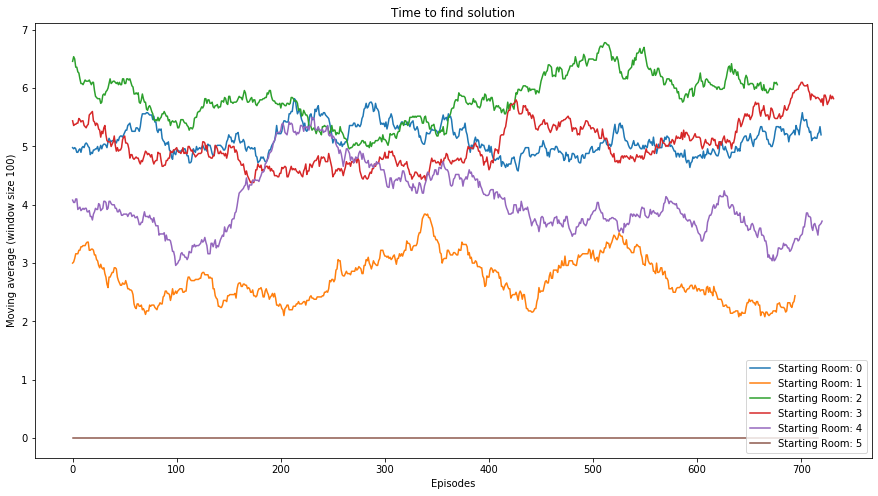

In [100]:
# plot the history as a moving average
import matplotlib.pyplot as plt

def moving_average(a, n):
  # https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
  ret = np.cumsum(a, dtype=float)
  ret[n:] = ret[n:] - ret[:-n]
  return ret[n - 1:] / n

fig, ax = plt.subplots(figsize=(15, 8))

window_size = 100
for start, ts in history.items():
  ax.plot(moving_average(ts, window_size), label=f'Starting Room: {start}')

ax.set_title(f'Time to find solution')
ax.set_xlabel(f'Episodes')
ax.set_ylabel(f'Moving average (window size: {window_size})')

ax.legend()
plt.show()

In [101]:
bender_v2.Q

array([[  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,  80.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,  80.],
       [  0., 100.,   0.,   0., 100., 180.]])

## More Advanced Agents

You can install baselines, which contain implementation of more sophisticated agents.

https://github.com/openai/baselines